In [1]:
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_mpl_presets
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import warnings
import vice
import sys
load_mpl_presets()
warnings.filterwarnings("ignore")
print(sys.version_info)

/var/home/johnson.7419.local/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)


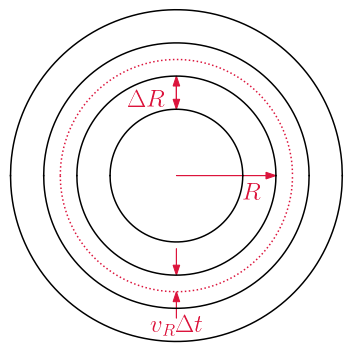

In [2]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlim([-5.1, 5.1])
ax.set_ylim([-5.1, 5.1])
ax.axis("off")

def plot_circle(radius, **kwargs):
    xvals = np.linspace(-radius, radius, 1000)
    yvals = [np.sqrt(radius**2 - x**2) for x in xvals]
    ax.plot(xvals, yvals, **kwargs)
    yvals = [-np.sqrt(radius**2 - x**2) for x in xvals]
    ax.plot(xvals, yvals, **kwargs)

kwargs = {"c": named_colors()["black"]}
for _ in [2, 3, 4, 5]: plot_circle(_, **kwargs)
plot_circle(3.5, c = named_colors()["crimson"], linestyle = ':')
kwargs = {
    "color": named_colors()["crimson"],
    "length_includes_head": True,
    "head_width": 0.2
}
ax.arrow(0, 0, 3, 0, **kwargs)
ax.arrow(0, 2, 0, 1, **kwargs)
ax.arrow(0, 3, 0, -1, **kwargs)
ax.arrow(0, -4.3, 0, 0.8, **kwargs)
ax.arrow(0, -2.2, 0, -0.8, **kwargs)
ax.text(-1.5, 2.1, r"$\Delta R$", color = kwargs["color"], fontsize = 25)
ax.text(2, -0.7, r"$R$", color = kwargs["color"], fontsize = 25)
ax.text(-0.8, -4.7, r"$v_R \Delta t$", color = kwargs["color"], fontsize = 25)

plt.tight_layout()
plt.savefig("../paper/figures/radialflows_schematic.pdf")
plt.show()

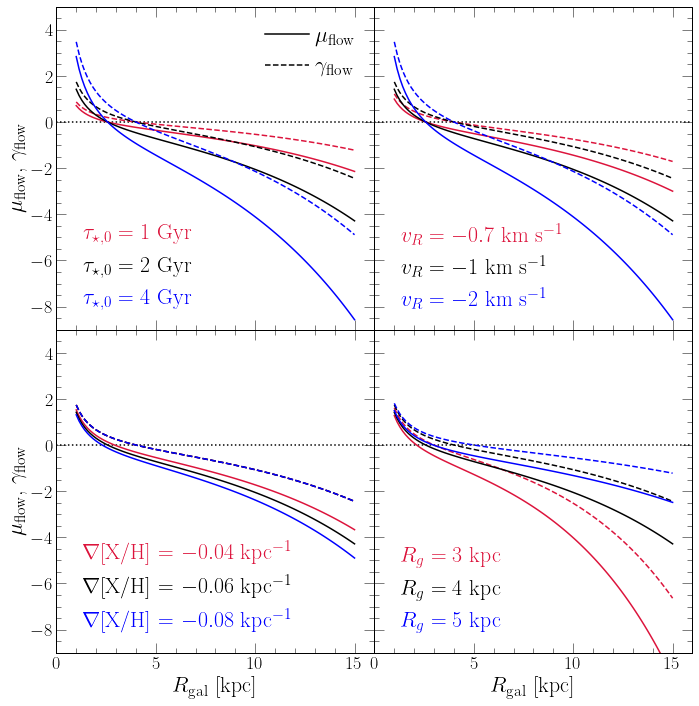

In [6]:
_SECONDS_PER_GYR_ = 3.1536e16
_KM_PER_KPC_ = 3.24e-17

def ralpha(A):
    r"""
    The e-folding scale radius of the metallicity gradient by mass.
    
    See :math:`R_\alpha` in notes above.
    """
    return -1 / (A * np.log(10))

def mu_flow(taustar, vr, A, rg, R):
    vr *= _SECONDS_PER_GYR_
    vr *= _KM_PER_KPC_ # vr now in kpc / Gyr
    return -taustar * vr * (1 / R - 1 / rg - 1 / ralpha(A))

def gamma_flow(taustar, vr, rg, R):
    vr *= _SECONDS_PER_GYR_
    vr *= _KM_PER_KPC_
    return -taustar * vr * (1 / R - 1 / rg)

def tau_star(radius, taustar0 = 2, Rg = 4, N = 1.5):
    return taustar0 * np.exp((N - 1) * radius / Rg)

fig = plt.figure(figsize = (10, 10))
axes = []
for i in range(4):
    kwargs = {}
    if i: kwargs["sharey"] = axes[0]
    axes.append(fig.add_subplot(221 + i, **kwargs))
    if i == 0 or i == 2:
#         axes[i].set_ylabel(r"$\mu_\text{flow} \equiv \dot{M}_{\alpha,\text{flow}} / \dot{M}_\star$",
#             fontsize = 22)
        axes[i].set_ylabel(r"$\mu_\text{flow}$, $\gamma_\text{flow}$", fontsize = 22)
    else:
        plt.setp(axes[i].get_yticklabels(), visible = False)
    if i >= 2:
        axes[i].set_xlabel(r"$R_\text{gal}$ [kpc]", fontsize = 22)
    else:
        plt.setp(axes[i].get_xticklabels(), visible = False)
    axes[i].set_xlim([0, 16])
    axes[i].set_ylim([-9, 5])
    axes[i].axhline(0, c = named_colors()["black"], linestyle = ':')
    
kwargs = {
    "c": named_colors()["black"],
    "label": r"$\mu_\text{flow}$"
}
line1 = axes[0].plot([-10, -20], [-10, -20], **kwargs)[0]
kwargs["linestyle"] = "--"
kwargs["label"] = r"$\gamma_\text{flow}$"
line2 = axes[0].plot([-10, -20], [-10, -20], **kwargs)[0]
kwargs = {
    "loc": mpl_loc("upper right"),
    "fontsize": 22
}
leg = axes[0].legend(**kwargs)
axes[0].add_artist(leg)
line1.remove()
line2.remove()

colors = ["crimson", "black", "blue"]
taustar0 = [1, 2, 4]
vr = [-0.7, -1, -2]
A = [-0.04, -0.06, -0.08]
rg = [3, 4, 5]

xvals = np.linspace(1, 15, 100)

for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\tau_{\star,0} = %g$ Gyr" % (taustar0[i])
    }
#     yvals = [mu_flow(taustar[i], vr[1], A[1], rg[1], x) for x in xvals]
    yvals = [mu_flow(tau_star(x, taustar0 = taustar0[i]), vr[1], A[1], rg[1], x) for x in xvals]
    axes[0].plot(xvals, yvals, **kwargs)
    kwargs["linestyle"] = "--"
    kwargs["label"] = None
    yvals = [gamma_flow(tau_star(x, taustar0 = taustar0[i]), vr[1], rg[1], x) for x in xvals]
    axes[0].plot(xvals, yvals, **kwargs)
    
for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$v_R = %g$ km s$^{-1}$" % (vr[i])
    }
#     yvals = [mu_flow(taustar[1], vr[i], A[1], rg[1], x) for x in xvals]
    yvals = [mu_flow(tau_star(x, taustar0 = taustar0[1]), vr[i], A[1], rg[1], x) for x in xvals]
    axes[1].plot(xvals, yvals, **kwargs)
    kwargs["linestyle"] = "--"
    kwargs["label"] = None
    yvals = [gamma_flow(tau_star(x, taustar0 = taustar0[1]), vr[i], rg[1], x) for x in xvals]
    axes[1].plot(xvals, yvals, **kwargs)
    
for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\nabla$[X/H] = $%g$ kpc$^{-1}$" % (A[i])
    }
#     yvals = [mu_flow(taustar[1], vr[1], A[i], rg[1], x) for x in xvals]
    yvals = [mu_flow(tau_star(x, taustar0 = taustar0[1]), vr[1], A[i], rg[1], x) for x in xvals]
    axes[2].plot(xvals, yvals, **kwargs)
    kwargs["linestyle"] = "--"
    kwargs["label"] = None
    yvals = [gamma_flow(tau_star(x, taustar0 = taustar0[1]), vr[1], rg[1], x) for x in xvals]
    axes[2].plot(xvals, yvals, **kwargs)

for i in range(3):
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$R_g = %g$ kpc" % (rg[i])
    }
#     yvals = [mu_flow(taustar[1], vr[1], A[1], rg[i], x) for x in xvals]
    yvals = [mu_flow(tau_star(x, taustar0 = taustar0[1], Rg = rg[i]), vr[1], A[1], rg[i], x) for x in xvals]
    axes[3].plot(xvals, yvals, **kwargs)
    kwargs["linestyle"] = "--"
    kwargs["label"] = None
    yvals = [gamma_flow(tau_star(x, taustar0 = taustar0[1], Rg = rg[i]), vr[1], rg[i], x) for x in xvals]
    axes[3].plot(xvals, yvals, **kwargs)

for i in range(4):
    kwargs = {
        "loc": mpl_loc("lower left"),
        "handlelength": 0,
        "fontsize": 22
    }
    leg = axes[i].legend(**kwargs)
    fancy_legend(leg, colors)

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.savefig("../paper/figures/muflow_gammaflow_vs_radius.pdf")
plt.show()